# Drive Rate EDA and Model
In this notebook, I will explore the relationships of different player stats and their future drive rate.  

Goals:
- Look for what stats might best predict drive rate.
- Find the best model to make accurate predictions.

Conclusions: 
- A player's future driving rate is almost entirely determined by their previous driving rates.

## 0. Importing Libraries and Data

In [3]:
# Importing standard libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Importing SKlearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, RFECV, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
# Importing created functions
from dictionaries import stat_types
from df_functions import use_history
from model_prep import corr_finder, data_split, feature_selection_corr, shift_data
from graphing import corr_plots, box_plots, graph_results

In [4]:
# Importing data
master_df = pd.read_csv('./data/master_df', index_col=0)

## 1. Create Train, Validate, and Test Sets
#### Create X and y

In [5]:
# Saving the data for all player seasons where they had at least 50 post-ups
post_index = master_df[(master_df['DRIVES'] * master_df['GP']) >= 50].index
data = master_df.loc[post_index]

In [6]:
# Matching player data with the target data in the following year
data = shift_data(data, 'PLAYER_ID', ['DRIVE_RATE'])

In [7]:
# Setting up the initial X and y
y = data.loc[:, ['TARGET_DRIVE_RATE']]
X = data.drop(columns='TARGET_DRIVE_RATE')

#### Splitting X and y into train, validate, and test sets

In [8]:
# Creating the train, validate, and test sets for post-up expected value
X_train, X_validate, X_test, y_train, y_validate, y_test = data_split(X, y, 'DRIVE_RATE')

## 2. Determine Potential Features
- We would expect to see more drives from guards so features like assist to passes, 3-6 dribble, and contested defensive rebounding were not surprisingly correlated with driving rate.

#### Finding correlated features

In [9]:
# Saving a list of possible numerical features
numeric_columns = list(data.dropna(axis=1).select_dtypes(['float', 'int']).columns)
numeric_columns.remove('TEAM_ID')
numeric_columns.remove('PLAYER_ID')
numeric_columns.remove('2018')

In [10]:
# Looking for features with the highest correlation with the target
corr_features = corr_finder(X_train[numeric_columns], y_train, .5, 10)

In [11]:
# Looking at the most correlated features with the target
corr_features

['DRIVE_RATE_WEIGHTED',
 'DRIVES_PER_MIN_WEIGHTED',
 'DRIVE_RATE',
 'DRIVES_PER_MIN',
 'DRIVE_FGA_PER_MIN_WEIGHTED',
 'DRIVE_FGA_PER_MIN',
 'DRIVE_PTS_PER_MIN_WEIGHTED',
 'DRIVE_FGM_PER_MIN_WEIGHTED',
 'DRIVE_PTS_PER_MIN',
 'DRIVE_FGM_PER_MIN']

In [12]:
# Finding the most correlated features that are not correlated with each other
corr_features = feature_selection_corr(X_train[numeric_columns], y_train['TARGET_DRIVE_RATE'], alpha=.5)

#### Graphing correlated features

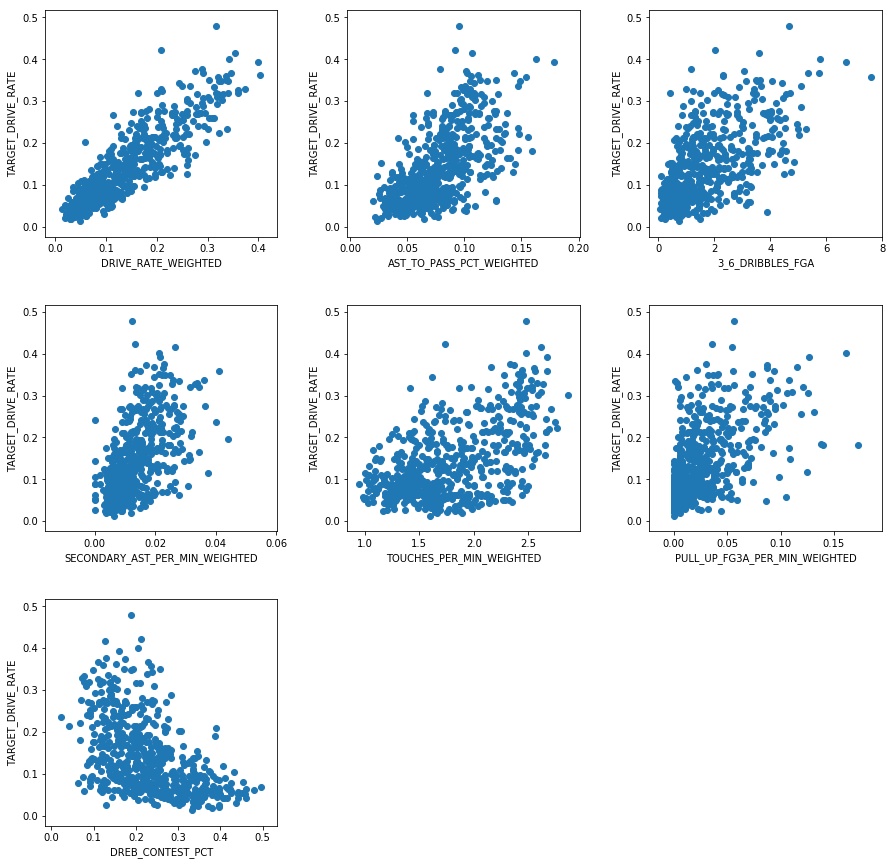

In [13]:
# Plotting those features
corr_plots(X_train, y_train, corr_features);

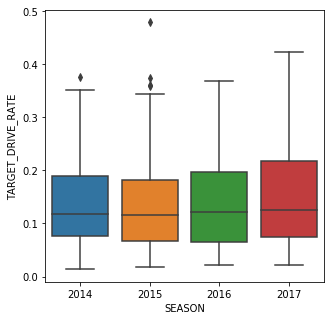

In [14]:
box_plots(X_train, y_train, ['SEASON'], cols=1)

#### Looking at driving and age

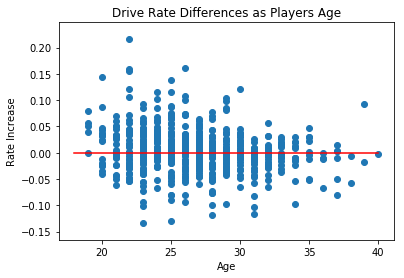

In [15]:
plt.scatter(X_train['AGE'], y_train['TARGET_DRIVE_RATE'] - X_train['DRIVE_RATE'])
plt.plot([18,40], [0,0], color='r')
plt.xlabel('Age')
plt.ylabel('Rate Increase')
plt.title('Drive Rate Differences as Players Age');

## 3. Modeling

#### RFECV
- Used significantly more features than any of the previous model (for other targets).
- Score was not that high for a rate target.

In [16]:
# Using recursive feature elimination to attempt to select features for the model
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True)
rfecv = RFECV(estimator=model, step=1, cv=kfolds)
rfecv.fit(X_train[numeric_columns], y_train.iloc[:,0])
rfecv.n_features_

76

In [17]:
# Checking which features were selected
X_train[numeric_columns].columns[rfecv.get_support(indices=True)]

Index(['SEASON', 'AST_PCT', 'DREB_CHANCE_PCT', 'DREB_CHANCE_PCT_ADJ',
       'VERY_TIGHT_FGA_FREQUENCY', 'VERY_TIGHT_FGM',
       'VERY_TIGHT_FG2A_FREQUENCY', 'VERY_TIGHT_FG2M', 'VERY_TIGHT_FG3M',
       'VERY_OPEN_FGA_FREQUENCY', 'VERY_OPEN_FG2A_FREQUENCY',
       'VERY_OPEN_FG3A_FREQUENCY', '3_6_DRIBBLES_FGA', '3_6_DRIBBLES_FG2A',
       '3_6_DRIBBLES_FG3A', 'SECONDARY_AST_PER_MIN', 'AST_ADJ_PER_MIN',
       'DIST_MILES_PER_MIN', 'OREB_UNCONTEST_PER_MIN', 'OREB_CHANCES_PER_MIN',
       'OREB_CHANCE_DEFER_PER_MIN', 'DREB_CONTEST_PER_MIN',
       'DREB_UNCONTEST_PER_MIN', 'DREB_CHANCES_PER_MIN', 'REB_CHANCES_PER_MIN',
       'REB_CHANCE_DEFER_PER_MIN', 'PULL_UP_FGM_PER_MIN',
       'PULL_UP_PTS_PER_MIN', 'PULL_UP_FG3A_PER_MIN',
       'ELBOW_TOUCH_FGM_PER_MIN', 'ELBOW_TOUCH_FTM_PER_MIN',
       'ELBOW_TOUCH_FTA_PER_MIN', 'ELBOW_TOUCH_PTS_PER_MIN',
       'TIGHT_FGA_PER_MIN', 'TIGHT_FG2A_PER_MIN', 'TIGHT_FG3M_PER_MIN',
       'TIGHT_FG3A_PER_MIN', 'VERY_TIGHT_FGM_PER_MIN',
       'VERY_

In [18]:
# Checking out the score with the validation data
rfecv.score(X_validate[numeric_columns], y_validate)

0.6339590476559664

#### K BEST
- 8 features did well in the cross-validation and validation scores.
- Used a bunch of driving rate features.

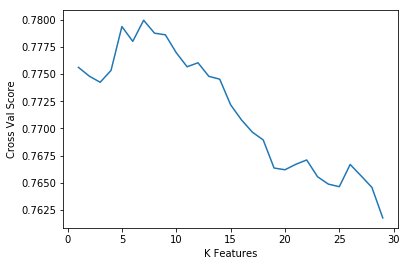

In [19]:
# Looping to select the best k for select k best feature selection
k_scores = []
for k in range(1, 30):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending cross val scores for those features
    model = LinearRegression()
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    k_scores.append(cross_val_score(model, X_train[model_features], y_train, cv=kfolds).mean())
    
plt.plot(range(1, 30), k_scores)
plt.xlabel('K Features')
plt.ylabel('Cross Val Score');

1  Feature Cross Val Scores:  [0.78310774 0.77323098 0.81192271 0.73455516 0.77525977]
2  Feature Cross Val Scores:  [0.78202386 0.75905375 0.8083981  0.74418947 0.78037169]
3  Feature Cross Val Scores:  [0.78320547 0.7594252  0.8013942  0.74573471 0.78145431]
4  Feature Cross Val Scores:  [0.78072389 0.76351343 0.80628489 0.74339533 0.7827561 ]
5  Feature Cross Val Scores:  [0.78422304 0.77288726 0.80812436 0.75166213 0.77994604]
6  Feature Cross Val Scores:  [0.78245775 0.76950703 0.80734625 0.75205069 0.77866701]
7  Feature Cross Val Scores:  [0.78797921 0.76640902 0.81512487 0.75888831 0.77134415]
8  Feature Cross Val Scores:  [0.78857676 0.76422547 0.81050199 0.75947156 0.77101577]
9  Feature Cross Val Scores:  [0.78922015 0.7626017  0.81096368 0.75843973 0.77182119]
10  Feature Cross Val Scores:  [0.78239423 0.75812061 0.81199837 0.75943898 0.77286574]


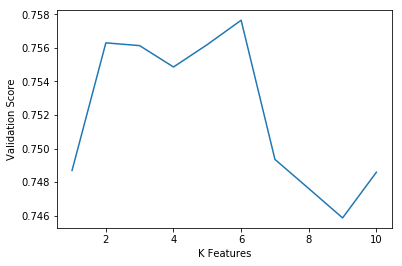

In [21]:
# Checking out 1 - 10 features
k_scores = []
for k in range(1, 11):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending the validation scores
    model = LinearRegression()
    model.fit(X_train[model_features], y_train)
    k_scores.append(model.score(X_validate[model_features], y_validate))
    
    # Printing out the cross val scores
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    print(k, ' Feature Cross Val Scores: ', cross_val_score(model, X_train[model_features], y_train, cv=kfolds))
    
# Graphing the validations scores
plt.plot(range(1, 11), k_scores)
plt.xlabel('K Features')
plt.ylabel('Validation Score');

In [22]:
# Printing out the scores with 6 features
k_best = SelectKBest(f_regression, k=6)
k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

0.7576472638443501

In [23]:
# Printing the model features
model_features

['DRIVE_RATE',
 'DRIVES_PER_MIN',
 'DRIVE_FGA_PER_MIN',
 'DRIVE_RATE_WEIGHTED',
 'DRIVES_PER_MIN_WEIGHTED',
 'DRIVE_FGA_PER_MIN_WEIGHTED']

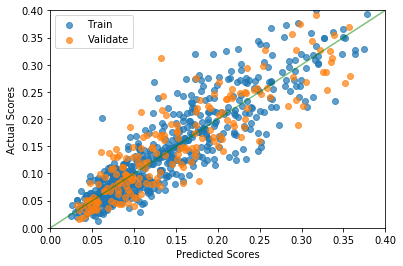

In [24]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_max=.4)

#### PCA
- The model does poorly compared to the previous ones.
- 2 features continues to seem the best based on the elbow method.

In [25]:
# Fitting PCA and checking the explained variance
pca = PCA(n_components=15)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_validate_scaled = scaler.transform(X_validate[numeric_columns])
pca.fit(X_train_scaled)
explained_var = pca.explained_variance_ratio_
explained_var

array([0.28391991, 0.18977627, 0.08356773, 0.04366046, 0.03419101,
       0.02498448, 0.02027815, 0.01886517, 0.01642542, 0.01484419,
       0.01401759, 0.01245616, 0.01093739, 0.0092048 , 0.00915873])

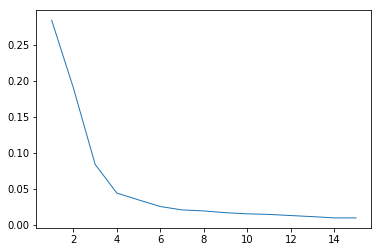

In [26]:
# Looking at the graph of explained variance and looking for the "elbow"
plt.plot(range(1, len(explained_var) + 1), explained_var, lw=1);

In [27]:
# Looking at the cross val score
pca = PCA(n_components=2)
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()
cross_val_score(model, pca.fit_transform(X_train_scaled), y_train, cv=kfolds)

array([0.60533451, 0.57328402, 0.55208095, 0.49063394, 0.43530818])

In [28]:
# Seeing the score on the validation set
model = LinearRegression()
model.fit(pca.transform(X_train_scaled), y_train)
model.score(pca.transform(X_validate_scaled), y_validate)

0.47607623940236987

#### Neural Net
- Graph has a strange pattern. Higher predicted scores were too low.
- Neural nets continue to struggle with this data.

In [29]:
# Preparing a neural net with all possible features
model_features = data[numeric_columns].dropna(axis=1).columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [30]:
# Creating the neural net
model = Sequential()
model.add(Dense(len(model_features), activation='relu', input_dim=len(model_features)))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/2), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/4), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/8), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/16), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/32), activation='relu', kernel_regularizer=regularizers.l2(.01)))
model.add(Dense(1, activation=None))

In [31]:
# Compiling the neural net and setting an early stopping feature
model.compile(loss='mean_squared_error', optimizer='adam')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50)

In [32]:
# Fitting the neural net
model.fit(X_train_scaled, y_train, validation_data=(X_validate_scaled, y_validate),epochs=1000,
          callbacks=[early], verbose=0);

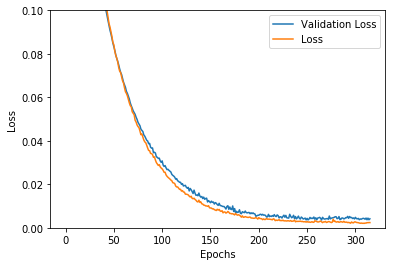

In [33]:
# Plotting the loss over epochs while training
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.plot(model.history.history['loss'], label='Loss')
plt.ylim(0,.1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [34]:
# Finding the r2 score on the validation set
r2_score(y_validate, model.predict(X_validate_scaled))

0.5187961969433246

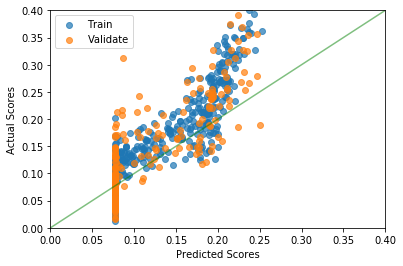

In [35]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, model, axis_max=.4)

#### Linear Regression with My Selected Features
- These features are based on correlations that I saw, features that go into post-up rate, and features that I wanted to experiment with.
- The scores were very consistent in the cross validation.

In [36]:
# Saving the model features
model_features = ['DRIVE_RATE_WEIGHTED', 'PULL_UP_RATE_WEIGHTED', 'POST_TOUCH_RATE_WEIGHTED', 'PLAYER_HEIGHT_INCHES',
                  'SKINNY', 'AGE', '2015', '2016', '2017']

In [37]:
# Finding the cross validation score
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_score(model, X_train[model_features], y_train, cv=kfolds)

array([0.7934791 , 0.78667058, 0.81805601, 0.75317745, 0.7888509 ])

In [38]:
# Checking the validation scores
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

0.7571607686154134

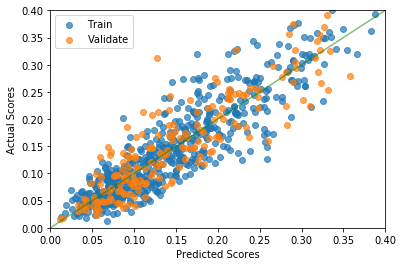

In [39]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_max=.4)

#### Regularized Linear Regression with My Selected Features
- These scores are very similar to the linear regression.
- Drive rate in the current season dominated both of their predictions.

In [40]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [41]:
# Testing out ridge regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_cv = RidgeCV(alphas=np.logspace(-1,3,100), cv=kfolds)
ridge_cv.fit(X_train_scaled, y_train)
ridge = Ridge(alpha=ridge_cv.alpha_)
cross_val_score(ridge, X_train_scaled, y_train, cv=kfolds)

array([0.79316586, 0.78813976, 0.81773795, 0.75365511, 0.78804007])

In [42]:
# Seeing the score on the validation set
ridge.fit(X_train_scaled, y_train)
ridge.score(X_validate_scaled, y_validate)

0.7575057735613435

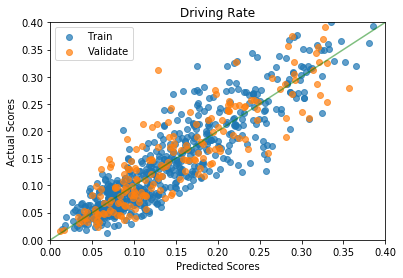

In [43]:
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, ridge, axis_max=.4)
plt.title('Driving Rate');

In [44]:
# Testing out lasso regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_cv = LassoCV(alphas=np.linspace(.01,1,100), cv=kfolds)
lasso_cv.fit(X_train_scaled, y_train)
lasso = Lasso(alpha=lasso_cv.alpha_)
cross_val_score(lasso, X_train_scaled, y_train, cv=kfolds)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.76228848, 0.77456518, 0.79589373, 0.73105627, 0.7579415 ])

In [45]:
# Seeing the score on the validation set
lasso.fit(X_train_scaled, y_train)
lasso.score(X_validate_scaled, y_validate)

0.7456758321758804

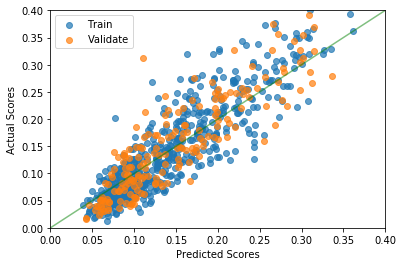

In [46]:
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, lasso, axis_max=.4)

In [47]:
# Looking at the selected features
lasso_coefs = pd.DataFrame(lasso.coef_, index=model_features, columns=['LASSO'])
ridge_coefs = pd.DataFrame(ridge.coef_, columns=model_features, index=['RIDGE']).T
pd.concat([lasso_coefs, ridge_coefs], axis=1)

,LASSO,RIDGE
DRIVE_RATE_WEIGHTED,0.068006,0.070920
PULL_UP_RATE_WEIGHTED,0.000000,0.003000
POST_TOUCH_RATE_WEIGHTED,-0.000000,-0.000373
PLAYER_HEIGHT_INCHES,-0.000000,-0.009454
SKINNY,0.000000,-0.005084
AGE,-0.000184,-0.011080
2015,-0.000000,-0.000599
2016,-0.000000,-0.000955
2017,0.000000,0.001958


#### Final scores (Ridge)
- The r2 score was reasonable given the cross validation scores.
- There was a 2.9 percent improvement in the rmse compared to the baseline using the test set.

In [48]:
# Ridge score on test data
X_test_scaled = scaler.transform(X_test[model_features])
r2_score(y_test, ridge.predict(X_test_scaled))

0.7920834525215323

In [49]:
# Root mean squared error
rmse = mean_squared_error(y_test, ridge.predict(X_test_scaled)) ** .5
rmse

0.04163063179844604

In [50]:
# The score if the prediction was just the value from the current year 
baseline = mean_squared_error(y_test, X_test['DRIVE_RATE']) ** .5
baseline

0.04287496415795732

In [51]:
# Looking at the percent improvement (test set)
1 - rmse/baseline

0.029022353346512153

#### Looking to correct the undervaluing/overvaluing problem (Future)

In [54]:
# Creating a training set
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
train['PREDICTED_DRIVE_RATE'] = ridge.predict(X_train_scaled)

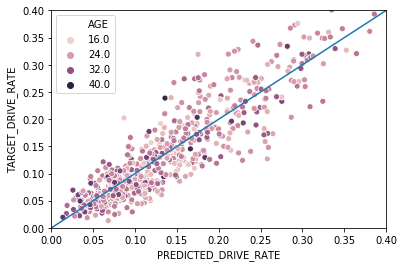

In [55]:
sns.scatterplot('PREDICTED_DRIVE_RATE', 'TARGET_DRIVE_RATE', data=train, hue='AGE')
plt.plot([0,.4], [0,.4])
plt.xlim(0, .4)
plt.ylim(0, .4);

#### Saving the predictions

In [71]:
# Loading the target dataframe
target_df = pd.read_csv('./data/target_df', index_col=0)

In [72]:
# Adding the predictions to the target dataframe
master_scaled = scaler.transform(master_df[model_features].dropna())
predictions = ridge.predict(master_scaled)
predictions_index = master_df[model_features].dropna().index
predictions_df = pd.DataFrame(predictions, columns=['PRED_DRIVE_RATE'], index=predictions_index)
target_df = pd.merge(target_df, predictions_df, how='left', left_index=True, right_index=True)

In [74]:
# Saving the dataframe
target_df.to_csv('./data/target_df')